In [1]:
# imports 

import sys
import time
import os
import warnings

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import numpy as np
import fitsio
from astropy.io import fits
import numpy.ma as ma

sys.path.insert(0, '/home/bekah/gphoton_working')
sys.path.insert(0, '/home/bekah/gphoton_working/gPhoton')

from photutils.aperture import CircularAperture
from photutils.utils import make_random_cmap
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

import pandas as pd 

from pyarrow import parquet

from gPhoton.parquet_utils import parquet_to_ndarray

from astropy.table import Table

from gPhoton.aspect import load_aspect_solution

from gPhoton.io.raw6 import load_raw6

from gPhoton.io._query.mast_query import retrieve_aspect
from gPhoton.io.mast import get_raw_paths 

In [ ]:
# eclipse with legs 
eclipse = 10982

In [14]:
# loading aspect table 
e2025  = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect.parquet',
                           filters=[('eclipse','=',9871)]).to_pandas()

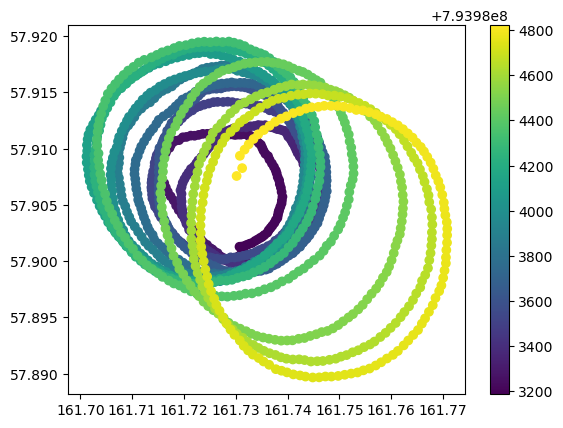

In [15]:
plt.scatter(e2025['ra'],e2025['dec'],c=e2025['time'])
plt.colorbar()

In [ ]:
# loading aspect table 
%matplotlib notebook
e10982  = parquet.read_table('/home/bekah/gPhoton2/gPhoton/aspect/aspect2.parquet',
                           filters=[('eclipse','=',10982)]).to_pandas()
plt.scatter(e10982['ra_acs'],e10982['dec_acs'],c=e10982['pktime'])
plt.colorbar()

In [ ]:
e10982

In [ ]:
# loading boresight table 
parq  = parquet.read_table('/home/bekah/gphoton_working/gPhoton/aspect/boresight.parquet')
bore = parq.to_pandas()

bore = bore[bore["eclipse"]==eclipse]

# show aspect table for that eclipse 
bore 

In [ ]:
def get_slew_data(eclipse, band, scstpath ):
    """
    Use SCST file to get missing slew data aka timestamps not available in
    the refined aspect soln that are in the scst file and are at HVNOM. 
    """
    from gPhoton.io.mast import get_raw_paths, download_data 
    #download scst 
    scst = download_data(
        eclipse, "scst", band, datadir=os.path.dirname(scstpath),
    )
    scst_pd = pd.DataFrame(scst[1].data)
    scst_pd = scst_pd.rename(columns={"pktime": "time"})
    
    # loading aspect table 
    parq  = parquet.read_table('/home/bekah/gphoton_working/gPhoton/aspect/aspect.parquet')
    aspect = parq.to_pandas()
    aspect = aspect[aspect["eclipse"]==eclipse]
    aspect = aspect.reset_index()
    
    #merge to get slew frames 
    merged_df = scst_pd.merge(aspect, how = 'left', on = ['time'])
    slew_frames = slew_frames[slew_frames['hvnom_nuv']==1]

    return slew_frames

In [ ]:
# scst files 
paths = get_raw_paths(eclipse)
paths['scst']

In [ ]:
%matplotlib notebook
plt.vlines(x=bore['time'],ymin = 0, ymax = max(aspect.index),color='red')
plt.scatter(aspect['time'],aspect.index)


In [ ]:

scst = fits.open("/home/bekah/gphoton_working/e10982-scst.fits.gz")
scst_pd = pd.DataFrame(scst[1].data)
scst_pd = scst_pd.rename(columns={"pktime": "time"})
merged_df = scst_pd.merge(aspect, how = 'left', on = ['time'])
slew_frames = merged_df[merged_df['ra'].isna()]
slew_frames = slew_frames[slew_frames['hvnom_nuv']==1]

slew_frames['ra'] = slew_frames['ra'].fillna(slew_frames['ra_acs'])
slew_frames['dec'] = slew_frames['dec'].fillna(slew_frames['dec_acs'])
slew_frames['roll'] = slew_frames['roll'].fillna(slew_frames['roll_acs'])

slew_frames

In [ ]:
scst[1].header

In [ ]:
indexlist = slew_frames.index.tolist()
chunklist = {}
counter = 0 
beginning = 0 
i = 0
while len(indexlist) > i + 1: 
    if indexlist[i]+1 != indexlist[i+1]: 
        # then next number is not consecutive 
        chunklist[counter] = indexlist[beginning:i+1]
        beginning = i+1 
        counter = counter + 1 
    i = i + 1 
print(chunklist)

In [ ]:
len(chunklist)

In [ ]:
scst[1].header

In [ ]:
mtype = scst[0].header['MPSTYPE']
legs = scst[0].header['MPSNPOS']
ra_cent = scst[0].header['RA_CENT']
dec_cent = scst[0].header['DEC_CENT']
visit = scst[0].header['VISIT']

In [ ]:
%matplotlib notebook
plt.scatter(slew_frames['dec_acs'],slew_frames["ra_acs"],c=slew_frames.index)
plt.xlabel('dec_acs from scst')
plt.ylabel('ra_acs from scst')
plt.colorbar()

In [ ]:
aspect_with_slew = add_slewframes(eclipse)

def add_slewframes(eclipse, file_names):
    """adds slewframes to aspect table for eclipse so that the slew
    frames can be added to photonlists"""
    from pyarrow import parquet
    from gPhoton.io.mast import get_raw_paths, download_data 

    # loading aspect table to add time stamp and flags
    parq = parquet.read_table(file_names['old_aspect_parq'])
    aspect = parq.to_pandas()
    aspect = aspect[aspect["eclipse"] == eclipse]
    aspect = aspect.reset_index()

    #download scst 
    scst = download_data(eclipse, "scst", band, datadir=os.path.dirname(scstpath),)
    scst_pd = pd.DataFrame(scst[1].data)
    scst_pd = scst_pd.rename(columns={"pktime": "time"})

    #merge to get slew frames 
    merged_df = scst_pd.merge(aspect, how = 'left', on = ['time'])
    slew_frames = slew_frames[slew_frames['hvnom_nuv']==1]
    
    # use acs solns for ra / dec / roll for slew frames in asp soln 
    slew_frames['ra'] = slew_frames['ra'].fillna(slew_frames['ra_acs'])
    slew_frames['dec'] = slew_frames['dec'].fillna(slew_frames['dec_acs'])
    slew_frames['roll'] = slew_frames['roll'].fillna(slew_frames['roll_acs'])
    
    slew_frames = slew_frames.astype({'ra': 'float64',
                          'dec': 'float64',
                          'roll': 'float64'})

    # save to parquet
    slew_frames.to_parquet(file_names["aspect_parq"], compression=None)
    
    return

In [ ]:
# from gphoton (won't actually run), cut to only leg-relevant parts of the function so I can
# understand what's happening 

def execute_photonpipe(ctx: PipeContext, raw6file: Optional[str] = None):
    """
    Apply static and sky calibrations to -raw6 GALEX data, producing fully
        aspect_data-corrected and time-tagged photon list files.
    :param ctx: PipeContext object containing pipeline parameters

    :type ctx: PipeContext

    :param raw6file: Name of the raw6 file to use.

    :type raw6file: str
    """
    # LOADING ASPECT SOLUTION
    aspect = load_aspect_solution(eclipse, ctx.aspect, ctx.verbose)
    # LOADING RAW6 
    data, nphots = load_raw6(raw6file, ctx.verbose)
    # CHUNK BY LEGS 
    legs = chunk_by_legs(aspect, ctx.chunksz, data, share_memory)
    del data
    # explode to dict of arrays for numba etc.
    results, addresses = {}, []
    for leg_ix in legs.keys():
        addresses += [(leg_ix, chunk_ix) for chunk_ix in legs[leg_ix].keys()]
    for leg_ix, chunk_ix in addresses:
        infix = f" (leg {leg_ix}) " if len(legs) > 1 else ""
        title = f"{(chunk_ix + 1) * (leg_ix + 1)}{infix}/ {len(addresses)}: "
        chunk = legs[leg_ix].pop(chunk_ix)
        process_args = (
            aspect,
            ctx.band,
            cal_data,
            chunk,
            title,
            stim_coefficients,
            xoffset,
            yoffset,
            ctx.extended_photonlist
        )
        if pool is None:
            results[(leg_ix, chunk_ix)] = chunk_function(*process_args)
        else:
            results[(leg_ix, chunk_ix)] = pool.apply_async(
                chunk_function, process_args
            )
        del process_args
        del chunk
    for leg_ix, leg_ctx in enumerate(ctx.explode_legs()):
        leg_results = {}
        leg_addresses = tuple(filter(lambda k: k[0] == leg_ix, results.keys()))
        for address in leg_addresses:
            leg_results[address[1]] = results.pop(address)
        array_dict = retrieve_leg_results(leg_results, share_memory)
        proc_count += len(array_dict["t"])
        # noinspection PyArgumentList
        print(f"writing table to {leg_ctx['photonfile']}")
        parquet.write_table(
            pyarrow.Table.from_arrays(
                list(array_dict.values()), names=list(array_dict.keys())
            ),
            leg_ctx['photonfile'],
            use_dictionary=FIELDS_FOR_WHICH_DICTIONARY_COMPRESSION_IS_USEFUL,
            version="2.6",
        )
        outfiles.append(leg_ctx['photonfile'])

In [ ]:
# TL;DR: RAW6 UNPACKING AND DECODING DOESNT SEEM TO BE GETTING RID OF ANY TIME CHUNKS 

def load_raw6(raw6file: Pathlike, verbose: int):
    """
    open and decode a GALEX raw telemetry (.raw6) file and return it as a
    DataFrame. This function replicates mission-standard L0 data processing.
    The dict returned by this function is gPhoton's canonical 'raw photon
    data' structure, used as an input to primary pipeline components
    (particularly photonpipe).

    :param raw6file: path/filename of raw6 file to load
    :param verbose: verbosity level -- higher is more messages
    :return:
    """
    if verbose > 0:
        print_inline("Loading raw6 file...      ")
    raw6hdulist = fitsio.FITS(raw6file)
    raw6header = raw6hdulist[0].read_header()
    raw6htab = raw6hdulist[1].read_header()
    band = "NUV" if raw6header["BAND"] == 1 else "FUV"
    eclipse = raw6header["ECLIPSE"]
    nphots = raw6htab["NAXIS2"]
    if verbose > 1:
        print(f"\n{nphots} events")
    data = decode_telemetry(band, eclipse, raw6hdulist)
    raw6hdulist.close()
    return data, nphots


def decode_telemetry(
    band: GalexBand, eclipse: int, raw6hdulist: fitsio.FITS
):
    """"""
    data = bitwise_decode_photonbytes(unpack_raw6(raw6hdulist))
    data = center_and_scale(band, data, eclipse)
    data["t"] = data["t"].astype("f8")
    return data


def unpack_raw6(raw6hdulist: fitsio.FITS) -> dict[
    Literal["t", 1, 2, 3, 4, 5], np.ndarray
]:
    """
    GALEX raw6 files are stored in a complex binary format. This function
    performs the first step in converting them to physically meaningful
    values: slicing the time and relevant 'photonbyte' columns from the FITS
    table structure, converting them to data types suitable for further
    processing, and placing them in a convenient data structure.
    """
    print_inline("Unpacking raw6 data...")
    photonbyte_cols = [f"phb{byte + 1}" for byte in range(5)]
    table_data = raw6hdulist[1][:][["t"] + photonbyte_cols]
    photonbytes_as_short = table_data[photonbyte_cols].astype(
        [(col, np.int16) for col in photonbyte_cols]
    )
    photonbytes = {}
    for byte in range(5):
        photonbytes[byte + 1] = photonbytes_as_short[photonbyte_cols[byte]]
    photonbytes["t"] = table_data["t"]
    # noinspection PyTypeChecker
    return photonbytes


def bitwise_decode_photonbytes(
    photonbytes: Mapping[Literal['t', 1, 2, 3, 4, 5], np.ndarray]
) -> dict[Literal["t", "xb", "xamc", "yb", "yamc", "q", "xa"], np.ndarray]:
    """
    GALEX photon events are stored in a packed binary format in the
    'photonbyte' (phb1 - phb6, though phb6 is unused) columns of raw6 files.
    this function 'decodes' these packed bytes into physically meaningful
    values.
    """
    data = {"t": photonbytes["t"]}
    data["xb"] = photonbytes[1] >> 5
    data["xamc"] = (
        np.array(((photonbytes[1] & 31) << 7), dtype="int16")
        + np.array(((photonbytes[2] & 254) >> 1), dtype="int16")
        - np.array(((photonbytes[1] & 16) << 8), dtype="int16")
    )
    data["yb"] = ((photonbytes[2] & 1) << 2) + ((photonbytes[3] & 192) >> 6)
    data["yamc"] = (
        np.array(((photonbytes[3] & 63) << 6), dtype="int16")
        + np.array(((photonbytes[4] & 252) >> 2), dtype="int16")
        - np.array(((photonbytes[3] & 32) << 7), dtype="int16")
    )
    data["q"] = ((photonbytes[4] & 3) << 3) + ((photonbytes[5] & 224) >> 5)
    data["xa"] = (
        ((photonbytes[5] & 16) >> 4)
        + ((photonbytes[5] & 3) << 3)
        + ((photonbytes[5] & 12) >> 1)
    )
    # noinspection PyTypeChecker
    return data


In [ ]:
def chunk_by_legs(aspect, chunksz, data, share_memory):
    # chunksz is ctx.chunksz, chunksz: Optional[int] = 1000000,

    chunks = {}
    bounds = []
    start = 0
    leg_groups = tuple(aspect.groupby('leg'))
    for leg_ix, leg in leg_groups:
        times = leg['time']
        start_ix = np.nonzero(data['t'][start:] >= times.iloc[0])[0][0]
        end_ix = np.nonzero(data['t'][start:] <= times.iloc[-1])[0][-1]
        bounds.append((start + start_ix, start + end_ix))
        leg_data = {
            field: data[field][start + start_ix:start + end_ix]
            for field in data.keys()
        }
        start += end_ix
        if share_memory is True:
            chunks[leg_ix] = slice_into_shared_chunks(chunksz, leg_data)
        else:
            chunks[leg_ix] = chunk_data(chunksz, leg_data, copy=True)
    return chunks


In [ ]:
def get_legs(eclipse):
    from gPhoton.aspect import aspect_tables

    return tuple(range(len(aspect_tables(eclipse, ("boresight",))[0]["time"])))

In [ ]:
def distribute_legs(
    aspect: pd.DataFrame, boresight: pd.DataFrame
) -> pd.DataFrame:
    """
    assign per-leg boresight positions to full-resolution aspect data.
    boresight positions are given in the original GALEX corpus separately
    from full-resolution aspect data. One nominal boresight position exists
    for each "leg" of a visit. For observations with more than one "leg",
    it is important to accurately assign a boresight position to each
    full-resolution aspect data point.
    """
    aspect = pd.DataFrame(aspect)
    boresight = pd.DataFrame(boresight)
    legframes = []
    for leg_ix in boresight.index:
        leg = boresight.loc[leg_ix]
        time_pred = aspect["time"] >= leg["time"]
        if leg_ix != len(boresight) - 1:
            time_pred = time_pred & (
                aspect["time"] < boresight.loc[leg_ix + 1]["time"]
            )
        leg_indices = aspect.loc[time_pred].index
        leg_arrays = {
            'ra0': np.full(len(leg_indices), leg['ra0']),
            'dec0': np.full(len(leg_indices), leg['dec0']),
            'leg': np.full(len(leg_indices), leg_ix, dtype=np.uint8)
        }
        legframes.append(pd.DataFrame(leg_arrays))
    distributed = pd.concat(legframes).reset_index(drop=True)
    return pd.concat([aspect, distributed], axis=1)


In [ ]:
def centile_clip(image, centiles=(0, 90)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

In [ ]:
%matplotlib notebook
dose_ais = fits.open("/home/bekah/gphoton_working/test_data/e10982/e10982-nd-t0002-b01-f0059-g_dose.fits.gz")
plt.imshow(centile_clip(dose_ais[0].data,(0,99.95)), interpolation=None)
#plt.imshow(dose_ais[0].data, interpolation=None)

In [ ]:
plt.hist(dose_ais[0].data)

In [ ]:
from skimage import data

image = data.camera()
pixelated = image[::10, ::10]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(image)
ax1.imshow(pixelated) 

In [ ]:
from skimage import filters
%matplotlib notebook
smooth = filters.gaussian(dose_ais[0].data, sigma=2)
#smooth = filters.sobel(dose_ais[0].data)
plt.imshow(centile_clip(smooth,(0,99.95)), interpolation=None)

In [ ]:
from skimage.morphology import disk
from skimage.util import img_as_ubyte
%matplotlib notebook
neighborhood = disk(radius=1)  # "selem" is often the name used for "structuring element"
median = filters.rank.median(img_as_ubyte(dose_ais[0].data), neighborhood)
plt.imshow(centile_clip(median,(0,99.95)), interpolation=None)

In [ ]:
hdu = fits.PrimaryHDU(smooth)
hdul = fits.HDUList([hdu])
hdul.writeto('smooth_f59.fits')

In [ ]:
# settings that seem to work reasonably well with ASTRIDE for frame 60 of leg 1 

# Import the ASTRiDE library.
from astride import Streak

streak = Streak('/home/bekah/glcat/smooth_f59.fits', contour_threshold=4, min_points=1800, 
                radius_dev_cut=0.3, shape_cut=0.1)

# Detect streaks.
streak.detect()

# Write outputs and plot figures.
streak.write_outputs()
streak.plot_figures()

#print(streak.raw_borders)

In [ ]:
streaks = pd.read_csv("/home/bekah/glcat/smoothf62/streaks.txt",sep=' ')
streaks

In [ ]:
streaks['x_diff']=streaks['x_min']-streaks['x_max']
streaks['y_diff']=streaks['y_min']-streaks['y_max']

In [ ]:
ymax = max(abs(streaks['y_diff']))
xmax = max(abs(streaks['x_diff']))
slope = ymax / xmax 
slope

In [ ]:
yvals = np.load('/home/bekah/yvals.npy', allow_pickle=True) 
xvals = np.load('/home/bekah/xvals.npy', allow_pickle=True) 
%matplotlib notebook
fig, ax= plt.subplots()
x = np.linspace(0,4000,5)
for i in range(len(xvals)):
    ax.scatter(xvals[i], yvals[i],s=0.5)
    #y = streaks['slope'].iloc[i]*x+streaks['intercept'].iloc[i]
    #ax.plot(x,y)

In [ ]:
plt.imshow(filters.butterworth(
                dose_ais[0].data,
                cutoff_frequency_ratio=.05,
                order=5.0,
                high_pass=False,
            ))

In [ ]:
plt.imshow(filters.butterworth(
                dose_ais[0].data,
                cutoff_frequency_ratio=.02,
                order=5.0,
                high_pass=False,
            ))

In [ ]:
butter2 = filters.butterworth(
                dose_ais[0].data,
                cutoff_frequency_ratio=.06,
                order=10.0,
                high_pass=False,)
hdu = fits.PrimaryHDU(smooth)
hdul = fits.HDUList([hdu])
hdul.writeto('butter2.fits',overwrite=True)
plt.imshow(butter2)

In [ ]:
# image stacking code 

import numpy as np
import matplotlib.pyplot as plt

expt = 2 # 2 sec 
streaks = pd.read_csv("/home/bekah/glcat/smooth_f59/streaks.csv")

# calculate offsets 
streaks['x_diff']=streaks['x_min']-streaks['x_max']
streaks['y_diff']=streaks['y_min']-streaks['y_max']

# max offset 
ymax = max(abs(streaks['y_diff']))
xmax = max(abs(streaks['x_diff']))
ymean = np.mean(abs(streaks['y_diff']))
xmean = np.mean(abs(streaks['x_diff']))
slope = ymax / xmax
mean = np.mean(streaks['slope'])
print(f'calculated slope is {slope}, mean slope from streaks is {mean}.')
      
xrate = xmax / expt 
yrate = ymax / expt # used to be ymax / xmax

x_offset, y_offset = int(xrate*.1)-5, int(yrate*.1)-5 # Number of pixels to offset each image.
#x_offset, y_offset =  10,10
layers = 20

frames = int((59*2)/.1)
hdul = fits.open(f"/home/bekah/gphoton_working/test_data/e10982/e10982-nd-t00.1-b01-f{frames}-g_dose.fits.gz")
img1 = hdul[0].data
new_shape = ((layers - 1)*y_offset + img1.shape[0],
             (layers - 1)*x_offset + img1.shape[1])  
print(new_shape)
stacked = np.zeros(new_shape) #, dtype=np.float)
stacked2 = np.zeros(new_shape) #, dtype=np.float)

print(y_offset)
print(x_offset)
for layer in range(layers):
    print(layer)
    frame = frames + layer 
    frame2 = frames + layer + layers 

    dose_ais = fits.open(f"/home/bekah/gphoton_working/test_data/e10982/e10982-nd-t00.1-b01-f{frame}-g_dose.fits.gz")
    img1 = dose_ais[0].data #*layer # for tagging pixels as being from a layer  
    layer_op = (layers-1) - layer 
    stacked[layer_op*y_offset:layer_op*y_offset + img1.shape[0],
    layer_op*x_offset:layer_op*x_offset + img1.shape[1]] += img1
    
    dose_ais2 = fits.open(f"/home/bekah/gphoton_working/test_data/e10982/e10982-nd-t00.1-b01-f{frame2}-g_dose.fits.gz")
    img2 = dose_ais2[0].data #*layer # for tagging pixels as being from a layer  
    layer_op = (layers-1) - layer 
    stacked2[layer_op*y_offset:layer_op*y_offset + img2.shape[0],
    layer_op*x_offset:layer_op*x_offset + img2.shape[1]] += img2
    
plt.imsave('stacked.png', stacked, vmin=0, vmax=1)
hdu = fits.PrimaryHDU(stacked)
hdul = fits.HDUList([hdu])
hdul.writeto('stacked2.fits',overwrite=True)
hdu2 = fits.PrimaryHDU(stacked2)
hdul2 = fits.HDUList([hdu2])
hdul.writeto('stacked3.fits',overwrite=True)



In [ ]:
s = fits.open('/home/bekah/glcat/stacked2.fits')
sim = s[0].data
plt.imshow(centile_clip(sim,(0,99.99)),interpolation=None)
#plt.imshow(sim,interpolation=None)

In [ ]:
s = fits.open('/home/bekah/glcat/stacked3.fits')
sim = s[0].data
plt.imshow(centile_clip(sim,(0,99.99)),interpolation=None)

In [ ]:
sim

In [ ]:
dose_ais = fits.open("/home/bekah/gphoton_working/test_data/e10982/e10982-nd-t00.1-b01-f1175-g_dose.fits.gz")
plt.imshow(centile_clip(dose_ais[0].data,(0,99.999)), interpolation=None)

In [ ]:
# before running this, you have to have 2s backplanes and .1 s backplanes made for the correct leg / eclipse 

import numpy as np
import matplotlib.pyplot as plt


layers = 10 # how many images to add together (how many .1s frames, 10 would be 1 1s frame)
ones_frame = 123 # 1s exp t frame number 
f = round(ones_frame/2) # 2s exposure time frame number 
smoothed = f'smoothf{f}' # name of 2s smoothed image file 
expt = 2 # 2 sec 

############################################################################################################
# SMOOTHING 2s FRAME  
############################################################################################################

from skimage import filters

dose_ais = fits.open(f"/home/bekah/gphoton_working/test_data/e10982/e10982-nd-t0002-b01-f00{f}-g_dose.fits.gz")

smooth = filters.gaussian(dose_ais[0].data, sigma=2)

hdu = fits.PrimaryHDU(smooth)
hdul = fits.HDUList([hdu])
hdul.writeto(f'{smoothed}.fits')

############################################################################################################
# GETTING STREAKS 
############################################################################################################
# run test.py in terminal w Astride conda env activated 

"""# Import the ASTRiDE library.
from astride import Streak

# Read a fits image and create a Streak instance.
streak = Streak(f'/home/bekah/glcat/{smoothed}.fits', contour_threshold=4, min_points=1800, 
                radius_dev_cut=0.3, shape_cut=0.1)

# Detect streaks.
streak.detect()

# Write outputs and plot figures.
streak.write_outputs()
streak.plot_figures()"""

In [ ]:

streaks = pd.read_csv(f"/home/bekah/glcat/smoothf{f}/streaks.csv") 

############################################################################################################
# IMAGE STACKING 
############################################################################################################
# calculate offsets 
streaks['x_diff']=streaks['x_min']-streaks['x_max']
streaks['y_diff']=streaks['y_min']-streaks['y_max']

# max offset 
ymax = max(abs(streaks['y_diff']))
xmax = max(abs(streaks['x_diff']))
ymean = np.mean(abs(streaks['y_diff']))
xmean = np.mean(abs(streaks['x_diff']))
slope = ymax / xmax
mean = np.mean(streaks['slope'])
print(f'calculated slope is {slope}, mean slope from streaks is {mean}.')
      
xrate = xmax / expt 
yrate = ymax / expt # used to be ymax / xmax

x_offset, y_offset = int(xrate*.1)-5, int(yrate*.1)-5 # Number of pixels to offset each image.
#x_offset, y_offset =  10,10

frames = int((ones_frame)/.1)
hdul = fits.open(f"/home/bekah/gphoton_working/test_data/e10982/e10982-nd-t00.1-b01-f{frames}-g_dose.fits.gz")
img1 = hdul[0].data
new_shape = ((layers - 1)*y_offset + img1.shape[0],
             (layers - 1)*x_offset + img1.shape[1])  
print(new_shape)
stacked = np.zeros(new_shape) #, dtype=np.float)
stacked2 = np.zeros(new_shape) #, dtype=np.float)

print("y and x offset")
print(y_offset)
print(x_offset)

for layer in range(layers):
    print("adding image layers together")
    print(layer)
    frame = frames + layer 
    frame2 = frames + layer + layers 

    dose_ais = fits.open(f"/home/bekah/gphoton_working/test_data/e10982/e10982-nd-t00.1-b01-f{frame}-g_dose.fits.gz")
    img1 = dose_ais[0].data #*layer # for tagging pixels as being from a layer  
    layer_op = (layers-1) - layer 
    stacked[layer_op*y_offset:layer_op*y_offset + img1.shape[0],
    layer_op*x_offset:layer_op*x_offset + img1.shape[1]] += img1
    
# saving image to fits 

hdu = fits.PrimaryHDU(stacked)
hdul = fits.HDUList([hdu])
hdul.writeto('stacked2.fits',overwrite=True)

# opening image for DAO starfinder 

s = fits.open('/home/bekah/glcat/stacked2.fits')
sim = s[0].data

############################################################################################################
# ASPECT REF / XYLIST CALL 
############################################################################################################

# trying dao star finder / xylist call to astrometry.net instead of using an image run 

from photutils import DAOStarFinder
import subprocess 

daofind = DAOStarFinder(fwhm=4, threshold=1, sharplo=0.00)
star_list = daofind(sim)
tbl = star_list.to_pandas()
tbl

star_list = tbl.sort_values(by="flux", ascending=False)
colx = fits.Column(name='X', format='E', array=tbl['xcentroid'])
coly = fits.Column(name='Y', format='E', array=tbl['ycentroid'])
hdu = fits.BinTableHDU.from_columns([colx, coly])
tableName = "starlist_slew.fits"
hdu.writeto(tableName, overwrite=True)

print('getting image width and height')
h, w = sim.shape
print(f'height is {h} and width is {w}')

cmd = f"solve-field --overwrite -w {w} -e {h} " \
          f"--scale-units arcsecperpix --scale-low 1.0 --scale-high 1.5 " \
          f"--radius 5 '/home/bekah/glcat/starlist_slew.fits'"

subprocess.call(cmd, shell=True)

In [ ]:
# trying dao star finder instead of using an image run 

from photutils import DAOStarFinder
import subprocess 

daofind = DAOStarFinder(fwhm=4, threshold=1, sharplo=0.00)
star_list = daofind(sim)
tbl = star_list.to_pandas()
tbl

star_list = tbl.sort_values(by="flux", ascending=False)
colx = fits.Column(name='X', format='E', array=tbl['xcentroid'])
coly = fits.Column(name='Y', format='E', array=tbl['ycentroid'])
hdu = fits.BinTableHDU.from_columns([colx, coly])
tableName = "starlist_slew.fits"
hdu.writeto(tableName, overwrite=True)

print('getting image width and height')
h, w = sim.shape
print(f'height is {h} and width is {w}')

cmd = f"solve-field --overwrite -w {w} -e {h} " \
          f"--scale-units arcsecperpix --scale-low 1.0 --scale-high 1.5 " \
          f"--radius 5 '/home/bekah/glcat/starlist_slew.fits'"

subprocess.call(cmd, shell=True)
